# Analysis

## Imports and setup

In [1]:
import argparse
import pickle
from plotnine import *
import json
import pandas as pd
import os
import matplotlib.font_manager as fm
from matplotlib import rcParams
import itertools
import numpy as np
from scipy.stats import bootstrap, ttest_rel
from collections import defaultdict, Counter

from evaluate import data_generator
from axbench import LatentStatsEvaluator
from tqdm import tqdm

In [2]:
# set the theme
rcParams['font.family'] = "P052"
theme_set(theme_gray(base_family="P052") + theme(axis_text_x=element_text(angle=45, hjust=0.5)))

In [3]:
RESULTS_FOLDER = "/nlp/scr/wuzhengx/pyreax/axbench/results"
SUBFOLDERS = [
    "prod_2b_l10_concept500",
    "prod_2b_l20_concept500",
    "prod_9b_l20_concept500",
    "prod_9b_l31_concept500",
    # "prod_2b_l20_concept16k",
    # "prod_9b_l20_concept16k",
]
PLOT_FOLDER = "paper/"

METHODS = ["ig", "lsreft", "steering_vec", "sft", "probe", "no_grad", "crossfit", "lora", "loreft", "prompt_detection", "gemmascope_clamp"]
METHOD_MAP = {
    "LsReFT": "ReFT-r1",
    "SteeringVector": "SSV",
    "SparseLinearProbe": "Probe-SL",
    "DiffMean": "DiffMean",
    "PCA": "PCA",
    "LAT": "LAT",
    "GemmaScopeSAE": "SAE",
    "GemmaScopeSAEClamping": "SAE-c",
    "IntegratedGradients": "IG",
    "InputXGradients": "IxG",
    "LinearProbe": "Probe",
    "PromptSteering": "Prompt",
    "PromptDetection": "Prompt",
    "LoReFT": "LoReFT",
    "LoRA": "LoRA",
    "SFT": "SFT",
}
MODEL_MAP = {
    "2b": "Gemma-2-2B",
    "9b": "Gemma-2-9B",
}
LAYER_MAP = {
    "l10": "L10",
    "l20": "L20",
    "l31": "L31",
}
METRIC_MAP = {
    "macro_avg_accuracy": "Acc. (macro-avg)",
    "max_act": "Max Act.",
    "optimal_threshold": "Optimal Thresh.",
    "roc_auc": "ROC AUC",
    "max_lm_judge_rating": "Overall Score",
    "max_fluency_rating": "Fluency Score",
    "max_relevance_concept_rating": "Concept Score",
    "max_relevance_instruction_rating": "Instruct Score",
    "max_factor": "Steering Factor",
    "overall_accuracy": "Overall Accuracy",
    "f1": "F1",
    "precision": "Precision",
    "recall": "Recall",
}
FLOAT_METRICS = ['macro_avg_accuracy', 'max_act', 'optimal_threshold', 'roc_auc',
                 'max_lm_judge_rating', 'max_fluency_rating', 'max_relevance_concept_rating',
                 'max_relevance_instruction_rating', 'max_factor', 'overall_accuracy',
                 'f1', 'precision', 'recall', 'max_act_val', 'min_act_val']
INT_METRICS = ['concept_id']

def prettify_df(df):
    # rename columns
    for metric in FLOAT_METRICS:
        if metric in df.columns:
            df[metric] = df[metric].astype(float)
    for metric in INT_METRICS:
        if metric in df.columns:
            df[metric] = df[metric].astype(int)
    if "method" in df.columns:
        df["method"] = df["method"].apply(lambda x: METHOD_MAP.get(x, x))
        df = df.rename(columns={"method": "Method"})
    if "model" in df.columns:
        df["model"] = df["model"].apply(lambda x: MODEL_MAP.get(x, x))
    if "layer" in df.columns:
        df["layer"] = df["layer"].apply(lambda x: LAYER_MAP.get(x, x))
    df.columns = [METRIC_MAP[col] if col in METRIC_MAP else col for col in df.columns]
    return df


def mean_and_ci(group, n_bootstraps=1000, ci=0.95):
    values = group["values"].values
    # Compute mean
    mean_value = np.mean(values)
    if np.isnan(mean_value):
        print(values)
        print("bruh its nan")
    # Compute bootstrap CI
    result = bootstrap(
        data=(values,),
        statistic=np.mean,
        n_resamples=n_bootstraps,
        confidence_level=ci,
        method="percentile"
    )
    lower_ci, upper_ci = result.confidence_interval
    return pd.Series({"mean": mean_value, "lower_ci": lower_ci, "upper_ci": upper_ci})


def format_ci(mean, lower_ci, upper_ci, only_mean=False, percent=False):
    result = ""
    if only_mean:
        if percent:
            result = f"{mean:.1%}"
        else:
            result = f"{mean:.3f}"
    else:
        if percent:
            result = f"{mean:.1%}$^{{+{upper_ci-mean:.3f}}}_{{-{mean-lower_ci:.3f}}}$"
        else:
            result = f"{mean:.3f}$^{{+{upper_ci-mean:.3f}}}_{{-{mean-lower_ci:.3f}}}$"
    result = result.replace("%", "\\%")
    return result


def agg_first_non_nan(vals):
    for val in vals:
        if isinstance(val, list) or np.all(val):
            return val
    return np.nan


def split_metric(metric):
    splitted = metric.split(".")
    if len(splitted) > 4:
        splitted[3] = '.'.join(splitted[3:])
    return tuple(splitted[:4])

In [4]:
reload = True

In [5]:
# make plot folder if not exists
os.makedirs(PLOT_FOLDER, exist_ok=True)

all_dfs = []
if reload or not os.path.exists(f"{PLOT_FOLDER}/df.pkl"):
    for folder in SUBFOLDERS:
        parts = folder.split("_")
        assert len(parts) == 4
        _, model, layer, split = parts
        dfs = []
        for method in METHODS:
            method_folder = f"{RESULTS_FOLDER}/{folder}_{method}/evaluate"
            inference_folder = f"{RESULTS_FOLDER}/{folder}_{method}/inference"
            print(method, model, layer, split)
            if not os.path.exists(method_folder):
                continue
                
            # load latent eval
            megadict = defaultdict(dict)
            latent_eval = f"{method_folder}/latent.jsonl"
            if os.path.exists(latent_eval):
                print(f"Processing latent for {method}...")
                with open(latent_eval, "r") as f:
                    for line in f:
                        json_line = json.loads(line)
                        megadict[json_line['concept_id']]['latent'] = json_line['results']
            else:
                print(f"Skipping {method} because no latent.jsonl found")

            # load latent parquet
            if not os.path.exists(f"{inference_folder}/latent_data.parquet"):
                print(f"Skipping {method} because no latent.parquet found")
            else:
                print(f"Processing latent (more) for {method}...")
                df_generator = data_generator(inference_folder, mode="latent")
                for concept_id, temp_df in tqdm(df_generator, total=500):
                    eval_results = {}
                    for m in METHOD_MAP:
                        if f"{m}_max_act" not in temp_df.columns:
                            continue
                        evaluator = LatentStatsEvaluator(m)
                        eval_result = evaluator.compute_metrics(temp_df)
                        eval_results[m] = eval_result
                    if 'latent' not in megadict[concept_id]:
                        megadict[concept_id]['latent'] = {}
                    megadict[concept_id]['latent']['LatentStatsEvaluator'] = eval_results
            
            # load steering eval
            steering_eval = f"{method_folder}/steering.jsonl"
            if os.path.exists(steering_eval):
                print(f"Processing steering for {method}...")
                with open(steering_eval, "r") as f:
                    for line in f:
                        json_line = json.loads(line)
                        megadict[json_line['concept_id']]['steering'] = json_line['results']
            else:
                print(f"Skipping {method} because no steering.jsonl found")
            
            megalist = [{'concept_id': concept_id, **data} for concept_id, data in megadict.items()]
            df = pd.json_normalize(megalist)
            if "clamp" in method:
                df = df.rename(columns=lambda x: x.replace("GemmaScopeSAE", "GemmaScopeSAEClamping"))
                print(list(df.columns))
            dfs.append(df)
    
        # merge dfs based on concept_id column, pick the first one
        if len(dfs) == 0:
            continue
        df = pd.concat(dfs)
        # print(list(df.columns))
        # print("Duplicates:", len(df.duplicated(subset=["concept_id", "model", "layer"])))
        df = df.groupby("concept_id").first().reset_index()
        df["model"] = MODEL_MAP[model]
        df["layer"] = LAYER_MAP[layer]
        df["split"] = split
        df["identifier"] = f"{model}, {layer}, {split}"
        all_dfs.append(df)

    # save df
    df = pd.concat(all_dfs)
    df.to_pickle(f"{PLOT_FOLDER}/df.pkl")
else:
    df = pd.read_pickle(f"{PLOT_FOLDER}/df.pkl")

ig 2b l10 concept500
Processing latent for ig...
Processing latent (more) for ig...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 29.02it/s]


Skipping ig because no steering.jsonl found
lsreft 2b l10 concept500
Processing latent for lsreft...
Processing latent (more) for lsreft...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.18it/s]


Processing steering for lsreft...
steering_vec 2b l10 concept500
Processing latent for steering_vec...
Processing latent (more) for steering_vec...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.50it/s]


Processing steering for steering_vec...
sft 2b l10 concept500
Skipping sft because no latent.jsonl found
Skipping sft because no latent.parquet found
Processing steering for sft...
probe 2b l10 concept500
Processing latent for probe...
Processing latent (more) for probe...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.00it/s]


Processing steering for probe...
no_grad 2b l10 concept500
Processing latent for no_grad...
Processing latent (more) for no_grad...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 15.06it/s]


Processing steering for no_grad...
crossfit 2b l10 concept500
lora 2b l10 concept500
Skipping lora because no latent.jsonl found
Skipping lora because no latent.parquet found
Processing steering for lora...
loreft 2b l10 concept500
Skipping loreft because no latent.jsonl found
Skipping loreft because no latent.parquet found
Processing steering for loreft...
prompt_detection 2b l10 concept500
Processing latent for prompt_detection...
Processing latent (more) for prompt_detection...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.97it/s]


Skipping prompt_detection because no steering.jsonl found
gemmascope_clamp 2b l10 concept500
Skipping gemmascope_clamp because no latent.jsonl found
Processing latent (more) for gemmascope_clamp...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 15.01it/s]


Processing steering for gemmascope_clamp...
['concept_id', 'latent.LatentStatsEvaluator.DiffMean.positive_accuracy', 'latent.LatentStatsEvaluator.DiffMean.negative_accuracy', 'latent.LatentStatsEvaluator.DiffMean.hard_negative_accuracy', 'latent.LatentStatsEvaluator.DiffMean.precision', 'latent.LatentStatsEvaluator.DiffMean.recall', 'latent.LatentStatsEvaluator.DiffMean.f1', 'latent.LatentStatsEvaluator.DiffMean.macro_avg_accuracy_fixed', 'latent.LatentStatsEvaluator.DiffMean.overall_accuracy', 'latent.LatentStatsEvaluator.DiffMean.max_act_val', 'latent.LatentStatsEvaluator.DiffMean.min_act_val', 'latent.LatentStatsEvaluator.DiffMean.optimal_roc_threshold', 'latent.LatentStatsEvaluator.DiffMean.optimal_pr_threshold', 'latent.LatentStatsEvaluator.PCA.positive_accuracy', 'latent.LatentStatsEvaluator.PCA.negative_accuracy', 'latent.LatentStatsEvaluator.PCA.hard_negative_accuracy', 'latent.LatentStatsEvaluator.PCA.precision', 'latent.LatentStatsEvaluator.PCA.recall', 'latent.LatentStatsEva

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.94it/s]


Skipping ig because no steering.jsonl found
lsreft 2b l20 concept500
Processing latent for lsreft...
Processing latent (more) for lsreft...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.72it/s]


Processing steering for lsreft...
steering_vec 2b l20 concept500
Processing latent for steering_vec...
Processing latent (more) for steering_vec...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.40it/s]


Processing steering for steering_vec...
sft 2b l20 concept500
Skipping sft because no latent.jsonl found
Skipping sft because no latent.parquet found
Processing steering for sft...
probe 2b l20 concept500
Processing latent for probe...
Processing latent (more) for probe...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.65it/s]


Processing steering for probe...
no_grad 2b l20 concept500
Processing latent for no_grad...
Processing latent (more) for no_grad...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 15.04it/s]


Processing steering for no_grad...
crossfit 2b l20 concept500
lora 2b l20 concept500
Skipping lora because no latent.jsonl found
Skipping lora because no latent.parquet found
Processing steering for lora...
loreft 2b l20 concept500
Skipping loreft because no latent.jsonl found
Skipping loreft because no latent.parquet found
Processing steering for loreft...
prompt_detection 2b l20 concept500
Processing latent for prompt_detection...
Processing latent (more) for prompt_detection...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.22it/s]


Skipping prompt_detection because no steering.jsonl found
gemmascope_clamp 2b l20 concept500
Skipping gemmascope_clamp because no latent.jsonl found
Processing latent (more) for gemmascope_clamp...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 14.90it/s]


Processing steering for gemmascope_clamp...
['concept_id', 'latent.LatentStatsEvaluator.DiffMean.positive_accuracy', 'latent.LatentStatsEvaluator.DiffMean.negative_accuracy', 'latent.LatentStatsEvaluator.DiffMean.hard_negative_accuracy', 'latent.LatentStatsEvaluator.DiffMean.precision', 'latent.LatentStatsEvaluator.DiffMean.recall', 'latent.LatentStatsEvaluator.DiffMean.f1', 'latent.LatentStatsEvaluator.DiffMean.macro_avg_accuracy_fixed', 'latent.LatentStatsEvaluator.DiffMean.overall_accuracy', 'latent.LatentStatsEvaluator.DiffMean.max_act_val', 'latent.LatentStatsEvaluator.DiffMean.min_act_val', 'latent.LatentStatsEvaluator.DiffMean.optimal_roc_threshold', 'latent.LatentStatsEvaluator.DiffMean.optimal_pr_threshold', 'latent.LatentStatsEvaluator.PCA.positive_accuracy', 'latent.LatentStatsEvaluator.PCA.negative_accuracy', 'latent.LatentStatsEvaluator.PCA.hard_negative_accuracy', 'latent.LatentStatsEvaluator.PCA.precision', 'latent.LatentStatsEvaluator.PCA.recall', 'latent.LatentStatsEva

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.62it/s]


Skipping ig because no steering.jsonl found
lsreft 9b l20 concept500
Processing latent for lsreft...
Processing latent (more) for lsreft...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.99it/s]


Processing steering for lsreft...
steering_vec 9b l20 concept500
Processing latent for steering_vec...
Processing latent (more) for steering_vec...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.84it/s]


Processing steering for steering_vec...
sft 9b l20 concept500
probe 9b l20 concept500
Processing latent for probe...
Processing latent (more) for probe...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.10it/s]


Processing steering for probe...
no_grad 9b l20 concept500
Processing latent for no_grad...
Processing latent (more) for no_grad...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.50it/s]


Processing steering for no_grad...
crossfit 9b l20 concept500
lora 9b l20 concept500
Skipping lora because no latent.jsonl found
Skipping lora because no latent.parquet found
Processing steering for lora...
loreft 9b l20 concept500
Skipping loreft because no latent.jsonl found
Skipping loreft because no latent.parquet found
Processing steering for loreft...
prompt_detection 9b l20 concept500
Processing latent for prompt_detection...
Processing latent (more) for prompt_detection...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.28it/s]


Skipping prompt_detection because no steering.jsonl found
gemmascope_clamp 9b l20 concept500
Skipping gemmascope_clamp because no latent.jsonl found
Processing latent (more) for gemmascope_clamp...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 14.87it/s]


Processing steering for gemmascope_clamp...
['concept_id', 'latent.LatentStatsEvaluator.DiffMean.positive_accuracy', 'latent.LatentStatsEvaluator.DiffMean.negative_accuracy', 'latent.LatentStatsEvaluator.DiffMean.hard_negative_accuracy', 'latent.LatentStatsEvaluator.DiffMean.precision', 'latent.LatentStatsEvaluator.DiffMean.recall', 'latent.LatentStatsEvaluator.DiffMean.f1', 'latent.LatentStatsEvaluator.DiffMean.macro_avg_accuracy_fixed', 'latent.LatentStatsEvaluator.DiffMean.overall_accuracy', 'latent.LatentStatsEvaluator.DiffMean.max_act_val', 'latent.LatentStatsEvaluator.DiffMean.min_act_val', 'latent.LatentStatsEvaluator.DiffMean.optimal_roc_threshold', 'latent.LatentStatsEvaluator.DiffMean.optimal_pr_threshold', 'latent.LatentStatsEvaluator.PCA.positive_accuracy', 'latent.LatentStatsEvaluator.PCA.negative_accuracy', 'latent.LatentStatsEvaluator.PCA.hard_negative_accuracy', 'latent.LatentStatsEvaluator.PCA.precision', 'latent.LatentStatsEvaluator.PCA.recall', 'latent.LatentStatsEva

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.16it/s]


Skipping ig because no steering.jsonl found
lsreft 9b l31 concept500
Processing latent for lsreft...
Processing latent (more) for lsreft...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.97it/s]


Processing steering for lsreft...
steering_vec 9b l31 concept500
Processing latent for steering_vec...
Processing latent (more) for steering_vec...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.03it/s]


Processing steering for steering_vec...
sft 9b l31 concept500
probe 9b l31 concept500
Processing latent for probe...
Processing latent (more) for probe...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.99it/s]


Processing steering for probe...
no_grad 9b l31 concept500
Processing latent for no_grad...
Processing latent (more) for no_grad...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.27it/s]


Processing steering for no_grad...
crossfit 9b l31 concept500
lora 9b l31 concept500
Skipping lora because no latent.jsonl found
Skipping lora because no latent.parquet found
Processing steering for lora...
loreft 9b l31 concept500
Skipping loreft because no latent.jsonl found
Skipping loreft because no latent.parquet found
Processing steering for loreft...
prompt_detection 9b l31 concept500
Processing latent for prompt_detection...
Processing latent (more) for prompt_detection...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 56.30it/s]


Skipping prompt_detection because no steering.jsonl found
gemmascope_clamp 9b l31 concept500
Skipping gemmascope_clamp because no latent.jsonl found
Processing latent (more) for gemmascope_clamp...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 14.79it/s]


Processing steering for gemmascope_clamp...
['concept_id', 'latent.LatentStatsEvaluator.DiffMean.positive_accuracy', 'latent.LatentStatsEvaluator.DiffMean.negative_accuracy', 'latent.LatentStatsEvaluator.DiffMean.hard_negative_accuracy', 'latent.LatentStatsEvaluator.DiffMean.precision', 'latent.LatentStatsEvaluator.DiffMean.recall', 'latent.LatentStatsEvaluator.DiffMean.f1', 'latent.LatentStatsEvaluator.DiffMean.macro_avg_accuracy_fixed', 'latent.LatentStatsEvaluator.DiffMean.overall_accuracy', 'latent.LatentStatsEvaluator.DiffMean.max_act_val', 'latent.LatentStatsEvaluator.DiffMean.min_act_val', 'latent.LatentStatsEvaluator.DiffMean.optimal_roc_threshold', 'latent.LatentStatsEvaluator.DiffMean.optimal_pr_threshold', 'latent.LatentStatsEvaluator.PCA.positive_accuracy', 'latent.LatentStatsEvaluator.PCA.negative_accuracy', 'latent.LatentStatsEvaluator.PCA.hard_negative_accuracy', 'latent.LatentStatsEvaluator.PCA.precision', 'latent.LatentStatsEvaluator.PCA.recall', 'latent.LatentStatsEva

## Plots

In [6]:
# make each method a row
id_vars = ['concept_id', 'model', 'layer', 'split', 'identifier']
value_vars = [col for col in df.columns if col not in id_vars]
melted_df = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='metric', value_name='value')
melted_df["method"] = melted_df["metric"].apply(lambda x: METHOD_MAP.get(x.split(".")[2], x.split(".")[2]))
melted_df["metric"] = melted_df["metric"].apply(lambda x: ".".join(x.split(".")[3:]))
pivot_df = melted_df.pivot_table(index=id_vars + ['method'], columns='metric', values='value', aggfunc=agg_first_non_nan).reset_index()

# steering metrics
no_factor = ["Prompt", "LoReFT", "LoRA", "SFT"]
steering_metrics = ["lm_judge_rating", "fluency_ratings", "relevance_concept_ratings", "relevance_instruction_ratings"]
for metric in steering_metrics:
    pivot_df[metric] = pivot_df.apply(lambda row: np.mean(row[metric]) if isinstance(row[metric], list) and row["method"] in no_factor else row[metric], axis=1)
pivot_df["max_lm_judge_rating"] = pivot_df["lm_judge_rating"].apply(lambda x: max(x) if isinstance(x, list) else x)
pivot_df["max_lm_judge_rating_idx"] = pivot_df["lm_judge_rating"].apply(lambda x: np.argmax(x) if isinstance(x, list) else 0)
pivot_df["max_fluency_rating"] = pivot_df.apply(lambda row: row["fluency_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["fluency_ratings"], list) else row["fluency_ratings"], axis=1)
pivot_df["max_relevance_concept_rating"] = pivot_df.apply(lambda row: row["relevance_concept_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_concept_ratings"], list) else row["relevance_concept_ratings"], axis=1)
pivot_df["max_relevance_instruction_rating"] = pivot_df.apply(lambda row: row["relevance_instruction_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_instruction_ratings"], list) else row["relevance_instruction_ratings"], axis=1)
pivot_df["max_factor"] = pivot_df.apply(lambda row: row["factor"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["factor"], list) else row["factor"], axis=1)

# fix types
pivot_df = prettify_df(pivot_df)
no_factor = ["Prompt", "LoReFT", "LoRA", "SFT"]
print(pivot_df.head())
print("Columns:", sorted(list(pivot_df.columns)))
print(pivot_df.iloc[0])

# print duplicates
dups = pivot_df[pivot_df.duplicated(subset=["identifier", "concept_id", "Method"])].sort_values(by=["identifier", "concept_id", "Method"])
print("Duplicates:", len(dups))

   concept_id       model layer       split           identifier    Method  \
0           0  Gemma-2-2B   L10  concept500  2b, l10, concept500  DiffMean   
1           0  Gemma-2-2B   L10  concept500  2b, l10, concept500        IG   
2           0  Gemma-2-2B   L10  concept500  2b, l10, concept500       IxG   
3           0  Gemma-2-2B   L10  concept500  2b, l10, concept500       LAT   
4           0  Gemma-2-2B   L10  concept500  2b, l10, concept500      LoRA   

         F1                                             factor  \
0  0.985915  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   
1  0.637168                                                NaN   
2  0.637168                                                NaN   
3  0.679612  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   
4       NaN  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   

                                 fluency_completions  \
0  [The fluency of the sentence fragment is gener...   
1                     

In [7]:
df = pivot_df[pivot_df["split"] == "concept500"]
df

,concept_id,model,layer,split,identifier,Method,F1,factor,fluency_completions,fluency_ratings,...,ROC AUC,roc_curve.fpr,roc_curve.tpr,strength,Overall Score,max_lm_judge_rating_idx,Fluency Score,Concept Score,Instruct Score,Steering Factor
0,0,Gemma-2-2B,L10,concept500,"2b, l10, concept500",DiffMean,0.985915,"[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...",[The fluency of the sentence fragment is gener...,"[1.0, 1.2, 1.0, 1.0, 1.2, 1.0, 1.4, 1.2, 1.4, ...",...,0.996914,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, ...","[0.0, 0.027777777777777776, 0.5, 0.55555555555...","[8.00000011920929, 16.00000023841858, 24.00000...",0.680000,10,1.000000,1.200000,1.000000,2.5
1,0,Gemma-2-2B,L10,concept500,"2b, l10, concept500",IG,0.637168,NaN,NaN,NaN,...,0.546296,"[0.0, 0.0, 0.027777777777777776, 0.02777777777...","[0.0, 0.027777777777777776, 0.0277777777777777...",NaN,NaN,0,NaN,NaN,NaN,NaN
2,0,Gemma-2-2B,L10,concept500,"2b, l10, concept500",IxG,0.637168,NaN,NaN,NaN,...,0.263889,"[0.0, 0.027777777777777776, 0.0833333333333333...","[0.0, 0.0, 0.0, 0.027777777777777776, 0.027777...",NaN,NaN,0,NaN,NaN,NaN,NaN
3,0,Gemma-2-2B,L10,concept500,"2b, l10, concept500",LAT,0.679612,"[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...",[The sentence fragment demonstrates a generall...,"[1.0, 1.0, 1.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.541667,"[0.0, 0.027777777777777776, 0.1388888888888889...","[0.0, 0.0, 0.0, 0.027777777777777776, 0.027777...","[35.200000524520874, 70.40000104904175, 105.60...",0.240000,1,1.000000,0.200000,1.800000,0.4
4,0,Gemma-2-2B,L10,concept500,"2b, l10, concept500",LoRA,NaN,"[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...",[The sentence fragment demonstrates a generall...,1.114286,...,NaN,NaN,NaN,[],0.682857,0,1.114286,0.757143,1.671429,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26035,499,Gemma-2-9B,L31,concept500,"9b, l31, concept500",Prompt,0.886076,"[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...",[The fluency of this sentence fragment is gene...,1.142857,...,0.901235,"[0.0, 0.1111111111111111, 0.1388888888888889, ...","[0.0, 0.5555555555555556, 0.9722222222222222, ...",[],1.227143,0,1.142857,1.128571,2.000000,0.2
26036,499,Gemma-2-9B,L31,concept500,"9b, l31, concept500",ReFT-r1,0.880000,"[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...",[The provided text is a list of tips and is ge...,"[1.2, 1.0, 1.2, 1.0, 1.0, 0.8, 0.6, 0.2, 0.2, ...",...,0.960262,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.027777777777777776, 0.1944444444444444...","[32.00000047683716, 64.00000095367432, 96.0000...",0.960000,4,1.000000,0.800000,2.000000,1.0
26037,499,Gemma-2-9B,L31,concept500,"9b, l31, concept500",SAE,0.642857,"[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...",[The sentence fragment begins with a clear exp...,"[1.0, 1.6, 1.4, 1.2, 1.6, 1.0, 1.0, 1.2, 1.4, ...",...,0.500000,"[0.0, 1.0]","[0.0, 1.0]","[21.508800506591797, 43.017601013183594, 64.52...",0.300000,4,1.600000,0.200000,2.000000,1.0
26038,499,Gemma-2-9B,L31,concept500,"9b, l31, concept500",SAE-c,0.642857,"[0.4, 0.8, 1.2, 1.6, 2.0, 3.0, 4.0, 6.0, 8.0, ...",[The sentence fragment presents a list format ...,"[0.2, 0.4, 0.6, 0.8, 1.0, 1.4, 0.8, 0.6, 0.4, ...",...,NaN,NaN,NaN,"[43.017601013183594, 86.03520202636719, 129.05...",0.000000,0,0.200000,0.000000,0.400000,0.4


In [22]:
ignore = ["SAE-c"]

In [17]:
def winrate(row):
    method = "SAE"
    prompt_equivalent = df[(df["Method"] == method) & (df["identifier"] == row["identifier"]) & (df["concept_id"] == row["concept_id"])].iloc[0]
    if not isinstance(row["Overall Score"], (float, int)) or not isinstance(prompt_equivalent["Overall Score"], (float, int)):
        return np.nan
    return 1.0 if row["Overall Score"] > prompt_equivalent["Overall Score"] else 0.0 if row["Overall Score"] < prompt_equivalent["Overall Score"] else 0.5

df["Winrate"] = df.apply(lambda row: winrate(row), axis=1)

# make latex table
detection_order = []
steering_order = []
for metric in ["ROC AUC", "Overall Score", "Winrate", "Overall Accuracy", "F1", "Precision", "Recall"]:
    with open(f"{PLOT_FOLDER}/{split}_{metric}.txt", "w") as f:
        for only_mean in [True, False]:
            df_subset: pd.DataFrame = df.copy().dropna(subset=[metric])
            df_subset = df_subset.rename(columns={metric: "values"})[["Method", "identifier", "values"]]
            # print count of nans
            f.write("NaN count:\n")
            for method in df_subset["Method"].unique():
                f.write(f"{method}: {sum(df_subset[df_subset['Method'] == method]['values'].apply(lambda x: np.isnan(x)))}\n")
            avg_df = df_subset.copy()
            avg_df["identifier"] = "Average"
            df_subset = pd.concat([df_subset, avg_df])
            df_subset = df_subset.groupby(["identifier", "Method"]).apply(mean_and_ci).reset_index()
            
            # Append the averages to the original dataframe
            df_subset["values"] = df_subset.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
            df_subset = df_subset.pivot(index="Method", columns="identifier", values="values").reset_index()
            df_subset = df_subset.sort_values(by="Average", ascending=False)

            # df_subset_avg = df.copy()
            # df_subset_avg = df_subset_avg.rename(columns={metric: "values"})
            # df_subset_avg = df_subset_avg[["Method", "identifier", "values"]].groupby(["Method"]).apply(mean_and_ci).reset_index()
            # df_subset_avg["values"] = df_subset_avg.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
            # df_subset["Average"] = df_subset.apply(lambda row: df_subset_avg[df_subset_avg["Method"] == row["Method"]]["values"].values[0], axis=1)
            # df_subset = df_subset.sort_values(by="Average", ascending=False)
            if metric == "ROC AUC":
                detection_order = df_subset["Method"].tolist()
            elif metric == "Overall Score":
                steering_order = df_subset["Method"].tolist()
            elif metric in ["Winrate"]:
                df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=steering_order, ordered=True)
            else:
                df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=detection_order, ordered=True)
            flattened = df_subset.to_latex(index=False)
            f.write(flattened)
            f.write("\n\n")

        # do paired t test on Latent ROC AUC between each pair of methods
        df_subset = df.copy()[["Method", "identifier", "concept_id", metric]]
        df_subset = df_subset.pivot(index=["identifier", "concept_id"], columns="Method", values=metric).reset_index()
        for identifier in list(df_subset["identifier"].unique()) + [None]:
            for method1, method2 in itertools.combinations(df["Method"].unique(), 2):
                df_subset_t = df_subset[df_subset["identifier"] == identifier] if identifier is not None else df_subset
                if method1 not in df_subset_t.columns or method2 not in df_subset_t.columns:
                    continue
                roc_auc_1 = list(df_subset_t[method1])
                roc_auc_2 = list(df_subset_t[method2])
                # print all nans
                method1_nan = sum(np.isnan(roc_auc_1))
                method2_nan = sum(np.isnan(roc_auc_2))
                if method1_nan > 0 or method2_nan > 0:
                    # print(f"{method1} vs {method2}: skipping: {method1_nan}, {method2_nan}")
                    continue
                t_stat, p_value = ttest_rel(roc_auc_1, roc_auc_2, nan_policy="raise")
                f.write(f"{identifier}: {method1} vs {method2}: T-statistic: {t_stat}, P-value: {p_value} {'(Significant)' if p_value < 0.05 else ''}\n")

/tmp/aryaman/ipykernel_3466577/2032140011.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/aryaman/ipykernel_3466577/2032140011.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/aryaman/ipykernel_3466577/2032140011.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be exclud

In [24]:
df_all = df.copy()
df = df[~df["Method"].isin(ignore)]
df["Method"].unique()

array(['DiffMean', 'IG', 'IxG', 'LAT', 'LoRA', 'LoReFT', 'PCA', 'Probe',
       'Prompt', 'ReFT-r1', 'SAE', 'SFT', 'SSV'], dtype=object)

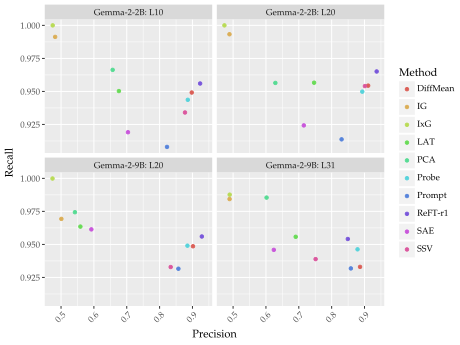

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_precision_vs_recall.pdf


In [25]:
%config InlineBackend.figure_format = 'svg'

# plot precision vs recall
split = "concept500"
df_subset = df.copy()
df_subset = df_subset[["Method", "model", "layer", "identifier", "Precision", "Recall"]]
df_subset = df_subset.dropna(subset=["Precision", "Recall"])
df_subset = df_subset.groupby(["identifier", "Method", "model", "layer"]).mean().reset_index()
plot = (
    ggplot(df_subset, aes(x="Precision", y="Recall", color="Method"))
    + facet_wrap('model + ": " + layer')
    + geom_point()
    + labs(x="Precision", y="Recall")
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_precision_vs_recall.pdf", width=4, height=3)

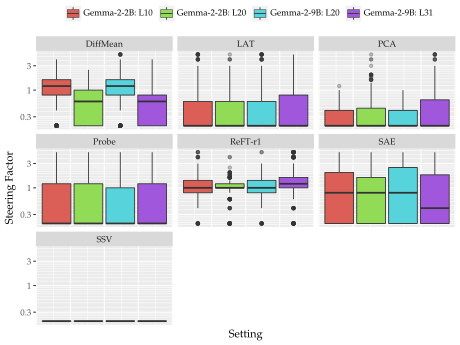

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_best_factor.pdf


In [26]:
# plot max_factor
df_subset = df.copy()
df_subset = df_subset.dropna(subset=["Steering Factor"])
df_subset = df_subset[~df_subset["Method"].isin(no_factor)]
# df_subset = df_subset.groupby(["Method", "model", "layer", "Steering Factor"]).count().reset_index()
# print(df_subset)
plot = (
    ggplot(df_subset, aes(y="Steering Factor", fill='model + ": " + layer'))
    + geom_boxplot(outlier_alpha=0.3)
    + facet_wrap("Method")
    # + geom_violin()
    # + stat_count(geom="point")
    + labs(x="Setting", y="Steering Factor", fill="")
    + scale_y_log10()
    + theme(legend_position="top", axis_text_x=element_blank(), axis_ticks_x=element_blank())
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_best_factor.pdf", width=6, height=4)

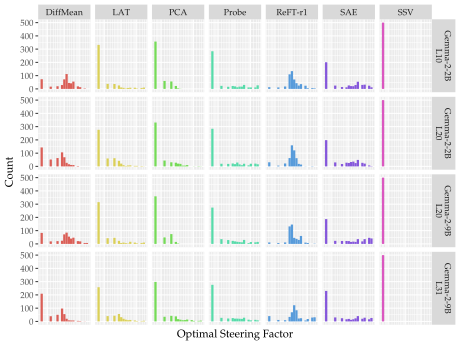

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_optimal_factor.pdf


In [27]:
# plot max_factor
df_subset = df.copy()
df_subset = df_subset.dropna(subset=["Steering Factor"])
df_subset = df_subset[~df_subset["Method"].isin(no_factor)]
# df_subset = df_subset.groupby(["Method", "model", "layer", "Steering Factor"]).count().reset_index()
# print(df_subset)
plot = (
    ggplot(df_subset, aes(x="Steering Factor", fill="Method"))
    + geom_histogram(bins=21)
    + facet_grid('model + layer ~ Method')
    # + geom_violin()
    # + stat_count(geom="point")
    + labs(x="Optimal Steering Factor", y="Count", fill="")
    + scale_x_log10()
    + theme(legend_position="none", axis_text_x=element_blank(), axis_ticks_x=element_blank())
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_optimal_factor.pdf", width=8, height=4)

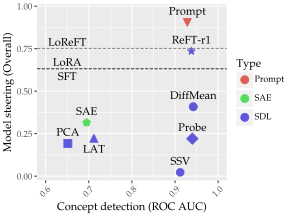

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_summary.pdf
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_summary.svg


In [28]:
# plot roc auc vs max lm judge rating
df_subset = df.copy()
df_subset = df_subset[["Method", "model", "layer", "identifier", "ROC AUC", "Overall Score"]]
df_subset2 = df_subset.dropna(subset=["ROC AUC", "Overall Score"])
df_subset2 = df_subset2.groupby(["identifier", "Method", "model", "layer"]).mean().reset_index()
df_subset2 = df_subset2[["Method", "ROC AUC", "Overall Score"]].groupby(["Method"]).mean().reset_index()
df_subset2["Color"] = df_subset2["Method"].map({
    "Prompt": "Prompt",
    "LoReFT": "Finetuning",
    "LoRA": "Finetuning",
    "SFT": "Finetuning",
    "SAE": "SAE",
    "ReFT-r1": "SDL",
    "DiffMean": "SDL",
    "Probe": "SDL",
    "SSV": "SDL",
    "LAT": "SDL",
    "PCA": "SDL",
})
# print(df_subset2)
plot = (
    ggplot(df_subset2, aes(x="ROC AUC", y="Overall Score", shape="Method", color="Color"))
    + geom_point(size=4)
    + geom_text(df_subset2[~df_subset2["Method"].isin(["LAT"])], aes(label="Method"), color="black", nudge_y=0.06)
    + geom_text(df_subset2[df_subset2["Method"].isin(["LAT"])], aes(label="Method"), color="black", nudge_y=-0.07)
    + labs(x="Concept detection (ROC AUC)", y="Model steering (Overall)", color="Type")
    + theme(legend_position="right", figure_size=(4, 3))
    + xlim(0.6, 1)
    + guides(shape="none")
)
df_subset3 = df_subset[df_subset["Method"].isin(["LoReFT", "LoRA", "SFT"])].groupby(["identifier", "Method", "model", "layer"]).mean().reset_index()
df_subset3 = df_subset3[["Method", "ROC AUC", "Overall Score"]].groupby(["Method"]).mean().reset_index()
plot += geom_hline(df_subset3, aes(yintercept="Overall Score"), alpha=0.5, linetype="dashed")
plot += geom_text(df_subset3[~df_subset3["Method"].isin(["SFT"])], aes(label="Method", y="Overall Score"), x=0.65, color="black", nudge_y=0.03)
plot += geom_text(df_subset3[df_subset3["Method"].isin(["SFT"])], aes(label="Method", y="Overall Score"), x=0.65, color="black", nudge_y=-0.05)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_summary.pdf", width=4, height=3)
plot.save(f"{PLOT_FOLDER}/{split}_summary.svg", width=4, height=3)

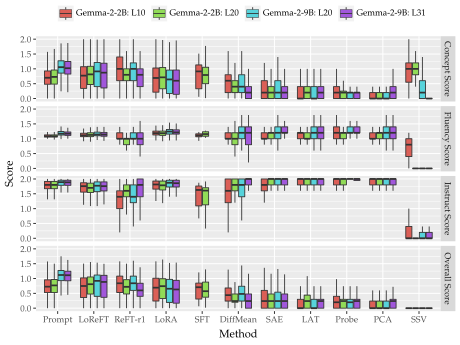

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 5 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_steering.pdf


In [33]:
# plot each steering metric
df_subset = df.copy()[["Method", "model", "layer", "identifier", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
df_subset = df_subset.dropna(subset=["Concept Score", "Instruct Score", "Fluency Score", "Overall Score", "model", "layer"])
df_subset = df_subset.melt(id_vars=["Method", "model", "layer", "identifier"], value_vars=["Concept Score", "Instruct Score", "Fluency Score", "Overall Score"], var_name="metric", value_name="value")
df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=[x for x in steering_order if x not in ignore])
plot = (
    ggplot(df_subset, aes(x="Method", y="value", fill='model + ": " + layer'))
    + facet_grid("metric~")
    # + facet_grid("model + layer ~")
    # + stat_summary(fun_data="mean_cl_boot", geom="bar", position="dodge")
    + geom_boxplot(outlier_shape="", position=position_dodge2(preserve="single"))
    # + geom_violin(position=position_dodge2())
    + labs(fill="", y="Score")
    + theme(legend_position="top", axis_text_x=element_text(angle=0, hjust=0.5))
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_steering.pdf", width=8, height=5)

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 2 rows containing missing values.


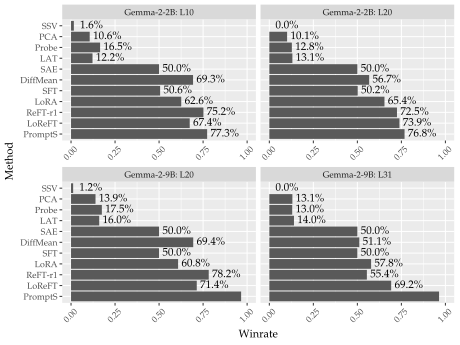

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 5 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_winrate.pdf
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 2 rows containing missing values.


In [15]:
# plot winrates
df_subset = df.copy()
df_subset = df_subset.dropna(subset=["Overall Score"])
methods = df_subset["Method"].unique()
df_subset = df_subset.pivot(index=id_vars, columns="Method", values="Overall Score").reset_index()
# print(df_subset)
def winrate(row, method):
    if not isinstance(row[method], (float, int)) or not isinstance(row["SAE"], (float, int)):
        return np.nan
    return 1.0 if row[method] > row["SAE"] else 0.0 if row[method] < row["SAE"] else 0.5
for method in methods:
    df_subset[method] = df_subset.apply(lambda row: winrate(row, method), axis=1)
df_subset = df_subset.melt(id_vars=id_vars, value_vars=methods, var_name="Method", value_name="Winrate")
df_subset["Count"] = 1
df_subset = df_subset.groupby(["Method", "identifier", "model", "layer", "split"]).sum().reset_index()
df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=steering_order)
df_subset["Winrate"] = df_subset["Winrate"] / df_subset["Count"]
df_subset["Text"] = df_subset["Winrate"].apply(lambda x: f"{x:.1%}")
df_subset = df_subset.dropna()
plot = (
    ggplot(df_subset, aes(y="Winrate", x="Method"))
    + facet_wrap('model + ": " + layer', scales="free_x")
    + geom_bar(stat="identity", position="stack")
    + geom_text(aes(label="Text", x="Method", y="Winrate"), position=position_stack(vjust=1.0), nudge_y=0.1)
    + labs(x="Method", y="Winrate")
    + coord_flip()
    + ylim(0, 1)
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_winrate.pdf", width=8, height=5)

In [35]:
# plot factor vs score
factor_df = df_all.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df = factor_df[~factor_df["Method"].isin(no_factor)]
factors = [val for val in factor_df["factor"]]
factor_dict = {
    "Steering Factor": [x for val in factor_df["factor"] for x in val],
    "Overall Score": [x for val in factor_df["lm_judge_rating"] for x in val],
    "Concept Score": [x for val in factor_df["relevance_concept_ratings"] for x in val],
    "Instruct Score": [x for val in factor_df["relevance_instruction_ratings"] for x in val],
    "Fluency Score": [x for val in factor_df["fluency_ratings"] for x in val],
}
lens = [len(val) for val in factors]
for col in id_vars + ["Method"]:
    factor_dict[col] = [val for i, val in enumerate(factor_df[col]) for _ in range(lens[i])]
factor_df_og = pd.DataFrame(factor_dict)
factor_df_og["Method"] = pd.Categorical(factor_df_og["Method"], categories=[x for x in steering_order if x not in no_factor])

/tmp/aryaman/ipykernel_3466577/3398011492.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


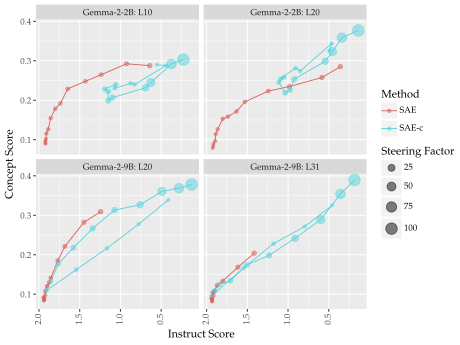

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_instruct_vs_concept_saec.pdf


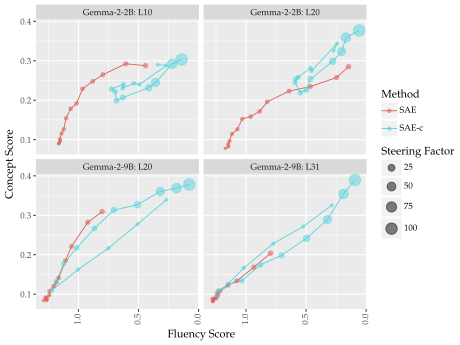

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_fluency_vs_concept_saec.pdf


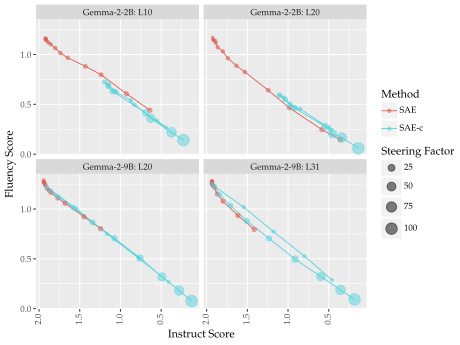

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_instruct_vs_fluency_saec.pdf


In [44]:
factor_df_subset = factor_df_og[["Method", "model", "layer", "identifier", "Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
factor_df_subset = factor_df_subset.groupby(["Method", "model", "layer", "identifier", "Steering Factor"]).mean().reset_index()
factor_df_subset = factor_df_subset.dropna(subset=["Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"])
factor_df_subset = factor_df_subset.sort_values(by="Steering Factor").reset_index()
factor_df_subset = factor_df_subset[factor_df_subset["Method"].isin(["SAE", "SAE-c"])]
factor_df_subset["Method"] = pd.Categorical(factor_df_subset["Method"], categories=["SAE", "SAE-c"])

for (x, y) in [("Instruct Score", "Concept Score"), ("Fluency Score", "Concept Score"), ("Instruct Score", "Fluency Score")]:
    plot = (
        ggplot(factor_df_subset, aes(x=x, y=y))
        + facet_wrap('model + ": " + layer')
        + geom_path(aes(color="Method", group="Method")) # arrow=arrow(type="closed", length=0.05)
        + geom_point(aes(color="Method", size="Steering Factor"), alpha=0.5)
        # + geom_text(aes(label="Steering Factor", size=0.2), alpha=0.5, nudge_y=0.04)
        + scale_x_reverse()
        + theme(axis_text_x=element_text(angle=90, hjust=0.5))
    )
    plot.show()
    plot.save(f"{PLOT_FOLDER}/{split}_{x.split()[0].lower()}_vs_{y.split()[0].lower()}_saec.pdf", width=6, height=4)

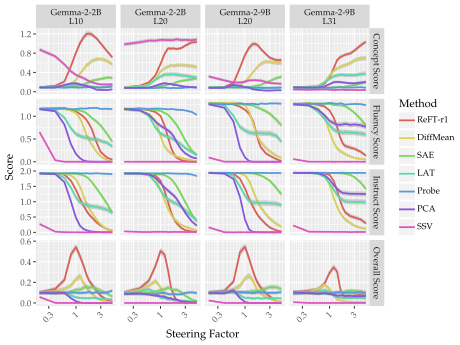

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 6 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_steering_factor.pdf


In [34]:
# plot factor vs score
factor_df = df.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df = factor_df[~factor_df["Method"].isin(no_factor)]
factors = [val for val in factor_df["factor"]]
factor_dict = {
    "Steering Factor": [x for val in factor_df["factor"] for x in val],
    "Overall Score": [x for val in factor_df["lm_judge_rating"] for x in val],
    "Concept Score": [x for val in factor_df["relevance_concept_ratings"] for x in val],
    "Instruct Score": [x for val in factor_df["relevance_instruction_ratings"] for x in val],
    "Fluency Score": [x for val in factor_df["fluency_ratings"] for x in val],
}
lens = [len(val) for val in factors]
for col in id_vars + ["Method"]:
    factor_dict[col] = [val for i, val in enumerate(factor_df[col]) for _ in range(lens[i])]
factor_df_og = pd.DataFrame(factor_dict)
factor_df_og["Method"] = pd.Categorical(factor_df_og["Method"], categories=[x for x in steering_order if (x not in no_factor) and (x not in ignore)])
factor_df = factor_df_og.melt(id_vars=id_vars + ["Method", "Steering Factor"], value_vars=["Overall Score", "Concept Score", "Instruct Score", "Fluency Score"], var_name="metric", value_name="value")
plot = (
    ggplot(factor_df, aes(x="Steering Factor", y="value", color="Method"))
    + stat_summary(fun_data="mean_cl_boot", geom="smooth")
    + scale_x_log10()
    + facet_grid("metric~model + layer", scales="free_y")
    + labs(x="Steering Factor", y="Score")
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_steering_factor.pdf", width=8, height=6)

/tmp/aryaman/ipykernel_3270154/3948226469.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


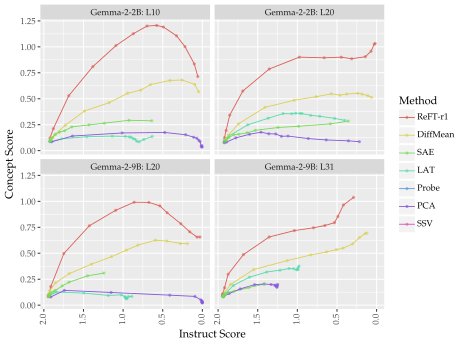

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 2.5 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_concept_vs_instruct.pdf


In [150]:
 # concept score vs instruct score for each method
factor_df_subset = factor_df_og[["Method", "model", "layer", "identifier", "Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
factor_df_subset = factor_df_subset.groupby(["Method", "model", "layer", "identifier", "Steering Factor"]).mean().reset_index()
factor_df_subset = factor_df_subset.dropna(subset=["Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"])
factor_df_subset = factor_df_subset.sort_values(by="Steering Factor").reset_index()
factor_df_subset = factor_df_subset[~factor_df_subset["Method"].isin(["SSV", "Probe"])]
plot = (
    ggplot(factor_df_subset, aes(x="Instruct Score", y="Concept Score"))
    + facet_wrap('model + ": " + layer')
    + geom_path(aes(color="Method", group="Method")) # arrow=arrow(type="closed", length=0.05)
    + geom_point(aes(color="Method"), alpha=0.5, size=0.8)
    # + geom_text(aes(label="Steering Factor", size=0.2), alpha=0.5, nudge_y=0.04)
    + scale_x_reverse()
    + theme(axis_text_x=element_text(angle=90, hjust=0.5))
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_concept_vs_instruct.pdf", width=4, height=2.5)

In [ ]:
 # concept score vs instruct score for each method
factor_df_subset = factor_df_og[["Method", "model", "layer", "identifier", "Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
factor_df_subset = factor_df_subset.groupby(["Method", "model", "layer", "identifier", "Steering Factor"]).mean().reset_index()
factor_df_subset = factor_df_subset.dropna(subset=["Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"])
factor_df_subset = factor_df_subset.sort_values(by="Steering Factor").reset_index()
factor_df_subset = factor_df_subset[~factor_df_subset["Method"].isin(["SSV", "Probe"])]
plot = (
    ggplot(factor_df_subset, aes(x="Instruct Score", y="Concept Score"))
    + facet_wrap('model + ": " + layer')
    + geom_path(aes(color="Method", group="Method")) # arrow=arrow(type="closed", length=0.05)
    + geom_point(aes(color="Method"), alpha=0.5, size=0.8)
    # + geom_text(aes(label="Steering Factor", size=0.2), alpha=0.5, nudge_y=0.04)
    + scale_x_reverse()
    + theme(axis_text_x=element_text(angle=90, hjust=0.5))
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_concept_vs_instruct.pdf", width=4, height=2.5)

In [113]:
# make a new df from the lists roc_curve.fpr and roc_curve.tpr
common_fpr = np.linspace(0, 1, 38)
roc_df = df.copy().dropna(subset=["roc_curve.fpr", "roc_curve.tpr"])
fprs = [val for val in roc_df["roc_curve.fpr"]]
tprs = [val for val in roc_df["roc_curve.tpr"]]
for i in range(len(fprs)):
    tprs[i] = [0.0] + list(np.interp(common_fpr, fprs[i], tprs[i]))
    fprs[i] = [0.0] + list(common_fpr)
roc_dict = {
    "fpr": [x for val in fprs for x in val],
    "tpr": [x for val in tprs for x in val],
}
# for key in ["fpr", "tpr"]:
#     for val in roc_df[f"roc_curve.{key}"]:
#         vals = []
#         for x in val:
#             if len(vals) != 0:
#                 if key == "fpr": vals.append(x)
#                 else: vals.append(vals[-1])
#             vals.append(x)
#         roc_dict[key].extend(vals)
lens = [len(val) for val in fprs]
for col in id_vars + ["Method"]:
    roc_dict[col] = [val for i, val in enumerate(roc_df[col]) for _ in range(lens[i])]
roc_df = pd.DataFrame(roc_dict)
roc_mean_df = roc_df.groupby(['model', 'layer', 'split', 'identifier', 'Method', 'fpr']).mean().reset_index()
roc_mean_df["Method"] = pd.Categorical(roc_mean_df["Method"], categories=detection_order)
roc_df["Method"] = pd.Categorical(roc_df["Method"], categories=detection_order)
print("Main ROC DF", len(roc_df))
print("Mean ROC DF", len(roc_mean_df))

Main ROC DF 780000
Mean ROC DF 1520


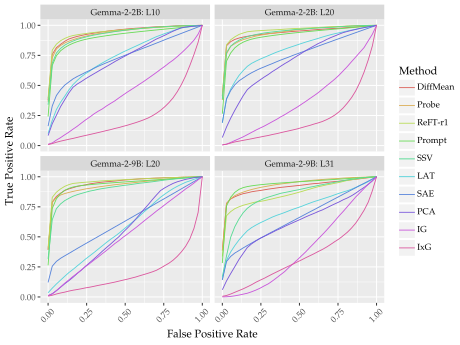

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_roc_mean.pdf


In [114]:
plot = (
    ggplot(roc_mean_df, aes(x="fpr", y="tpr", color="Method", group="Method"))
    + facet_wrap('model + ": " + layer')
    + geom_line()
    + labs(x="False Positive Rate", y="True Positive Rate")
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_roc_mean.pdf", width=4, height=3)

In [115]:
 plot = (
    ggplot(roc_df[(roc_df["model"] == "Gemma-2-2B") & (roc_df["layer"] == "L10")], aes(x="fpr", y="tpr", color="Method", group="concept_id"))
    + facet_grid("model + layer ~ Method")
    + geom_line(alpha=0.1)
    # + stat_summary(fun_data="mean_cl_boot", geom="line", color="black")
    + labs(x="False Positive Rate", y="True Positive Rate")
    + theme(legend_position="none", axis_text_x=element_text(angle=90, hjust=0.5))
)
# Add average ROC curve to the plot
plot += geom_line(roc_mean_df[(roc_mean_df["model"] == "Gemma-2-2B") & (roc_mean_df["layer"] == "L10")], aes(x="fpr", y="tpr"), color="black", size=1.0, alpha=0.5)
# plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_roc.pdf", width=8, height=1.75)

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 1.75 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_roc.pdf


In [116]:
plot = (
    ggplot(roc_df, aes(x="fpr", y="tpr", color="Method", group="concept_id"))
    + facet_grid("model + layer ~ Method")
    + geom_line(alpha=0.1)
    # + stat_summary(fun_data="mean_cl_boot", geom="line", color="black")
    + labs(x="False Positive Rate", y="True Positive Rate")
    + theme(legend_position="none")
)
# Add average ROC curve to the plot
plot += geom_line(roc_mean_df, aes(x="fpr", y="tpr"), color="black", size=1.0, alpha=0.5)
# plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_roc_all.pdf", width=8, height=5)

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 5 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_roc_all.pdf


In [ ]:
# make a plot for each metric
for metric in FLOAT_METRICS:
    metric_name = METRIC_MAP[metric]
    plot = (
        ggplot(
            df.dropna(subset=[metric_name]),
            aes(x="Method", y=metric_name, fill="layer")
        )
        + facet_grid("~model")
        + geom_boxplot(outlier_alpha=0.3)
        + labs(x="Method", y=metric_name)
        + ylim(min(0, df[metric_name].min()), max(1, df[metric_name].max()))
    )
    plot.save(f"{PLOT_FOLDER}/{split}_{metric}.pdf", width=8, height=5)

# Make scatter plots comparing each pair of float metrics
if pairs:
    for metric1, metric2 in itertools.combinations(FLOAT_METRICS, 2):
        metric1_name = METRIC_MAP[metric1]
        metric2_name = METRIC_MAP[metric2]
        
        plot = (
            ggplot(
                df.dropna(subset=[metric1_name, metric2_name]),
                aes(x=metric1_name, y=metric2_name, color="layer")
            )
            + facet_grid("identifier ~ Method")
            + geom_point(alpha=0.5)
            + labs(x=metric1_name, y=metric2_name)
            + theme(legend_position="right")
        )
        plot.save(f"{PLOT_FOLDER}/{split}_{metric1}_vs_{metric2}.pdf", width=12, height=8)

## Imbalanced dataset evals

In [7]:
!ls /nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_prompt_detection/inference_imbalance

all_negative_df.parquet  PromptDetection_latent_results.pkl


In [25]:
balance_results_dfs = []
for folder in SUBFOLDERS:
    parts = folder.split("_")
    assert len(parts) == 4
    _, model, layer, split = parts
    dfs = []
    for method in METHODS:
        if "prompt" not in method:
            continue
        inference_folder = f"{RESULTS_FOLDER}/{folder}_{method}/inference"
        imbalanced_inference_folder = f"{RESULTS_FOLDER}/{folder}_{method}/inference_imbalance"
        if not os.path.exists(imbalanced_inference_folder):
            continue

        # collect inference results on large negative set
        print("running on:")
        print(inference_folder)
        print(imbalanced_inference_folder)
        df_generator = data_generator(inference_folder, mode="latent")
        method_dfs = []
        for concept_id, temp_df in tqdm(df_generator, total=500):
            method_dfs.append(temp_df)

        # compute metrics when combining original balanced dataset with new large negative set
        results, orig_results = [], []
        for m in METHOD_MAP:
            imbalanced_data = f"{imbalanced_inference_folder}/{m}_latent_results.pkl"
            if not os.path.exists(imbalanced_data):
                continue
            print(f"METHOD: {m}")
            
            # load the imbalanced data
            with open(imbalanced_data, "rb") as f:
                neg_data = pickle.load(f)
            print(np.array(neg_data["max_act"]).shape)
            input()
            neg_df = pd.DataFrame(np.array(neg_data["max_act"]))
            neg_df = pd.melt(neg_df, id_vars=None)
            neg_df = neg_df.rename(columns={"variable": "concept"})
            evaluator = LatentStatsEvaluator(m)
            
            for concept in tqdm(range(500)):
                pos_df = method_dfs[concept]
                add_df = neg_df[neg_df["concept"] == concept][["value"]].copy()
                add_df["category"] = "negative"
                add_df = add_df.rename(columns={"value": f"{m}_max_act"})

                # compute combined vs. orig scores
                if f"{m}_max_act" not in pos_df.columns:
                    continue
                if "prompt" in imbalanced_data:
                    print(Counter(pd.concat([pos_df, add_df])["category"]))
                eval_result = evaluator.compute_metrics(pd.concat([pos_df, add_df]))
                eval_result_orig = evaluator.compute_metrics(pos_df)
                eval_result["concept_id"] = concept
                eval_result_orig["concept_id"] = concept
                results.append(eval_result)
                orig_results.append(eval_result_orig)

            for name, subset in {"imbalanced": results, "balanced": orig_results}.items():
                sub_df = pd.DataFrame.from_dict(subset)
                # sub_result = sub_df.mean().to_dict()
                # print(f"{m} ({name[:3]}.): {sub_result["f1"]:.4f} (f1), {sub_result["precision"]:.4f} (prec), {sub_result["recall"]:.4f} (rec), {sub_result["positive_accuracy"]:4f} (pos acc), {sub_result["negative_accuracy"]:4f} (neg acc)")
                sub_df["balancing"] = name
                sub_df["method"] = m
                sub_df["model"] = model
                sub_df["layer"] = layer
                sub_df["split"] = split
                balance_results_dfs.append(sub_df)

running on:
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_prompt_detection/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_prompt_detection/inference_imbalance


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1675.05it/s]


METHOD: PromptDetection
(3600,)


KeyboardInterrupt: Interrupted by user

In [10]:
balance_df = pd.concat(balance_results_dfs)
print(len(balance_df))
balance_df.head()

56000


,positive_accuracy,negative_accuracy,hard_negative_accuracy,precision,recall,f1,macro_avg_accuracy_fixed,overall_accuracy,max_act_val,min_act_val,optimal_roc_threshold,optimal_pr_threshold,concept_id,balancing,method,model,layer,split
0,0.861111,1.000000,1.0,1.000000,0.861111,0.925373,0.953704,0.998640,56.25,2.812,0.536846,0.621056,0,imbalanced,LsReFT,2b,l10,concept500
1,0.916667,1.000000,1.0,1.000000,0.916667,0.956522,0.972222,0.999184,78.00,0.000,0.288462,0.608974,1,imbalanced,LsReFT,2b,l10,concept500
2,0.916667,0.998900,1.0,0.891892,0.916667,0.904110,0.971856,0.998096,62.50,0.162,0.526773,0.635054,2,imbalanced,LsReFT,2b,l10,concept500
3,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,70.00,0.118,0.585015,0.585015,3,imbalanced,LsReFT,2b,l10,concept500
4,0.361111,0.966722,1.0,0.097015,0.361111,0.152941,0.775944,0.960848,36.75,0.000,0.435374,0.863946,4,imbalanced,LsReFT,2b,l10,concept500


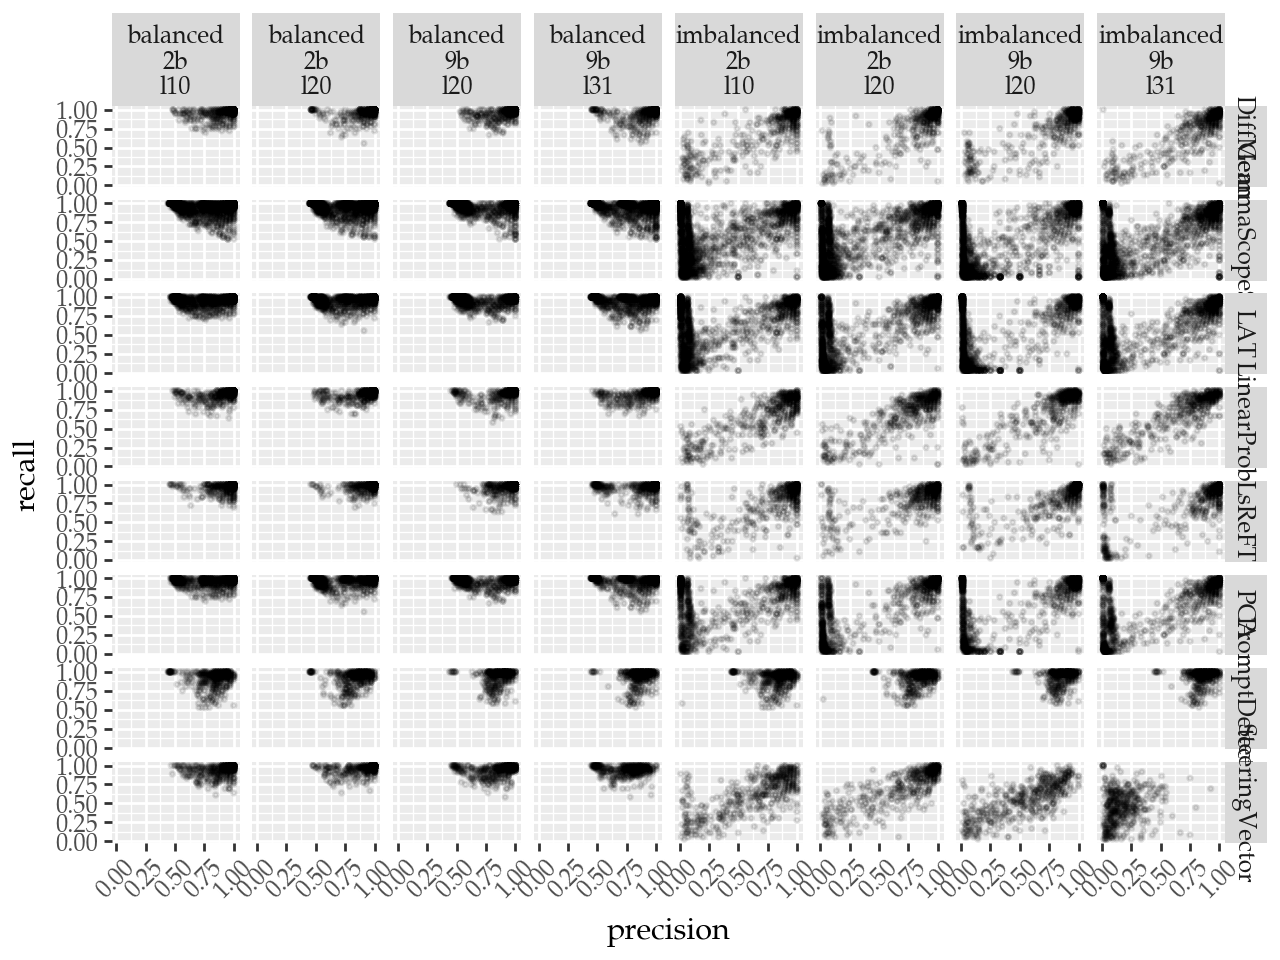

In [11]:
plot = (
    ggplot(balance_df, aes(x="precision", y="recall")) +
    facet_grid("method ~ balancing + model + layer") +
    geom_point(alpha=0.1, size=0.5)
)
plot.show()

In [17]:
balance_df2 = prettify_df(balance_df)
balance_df2 = balance_df2[["Method", "model", "layer", "F1", "balancing"]]
balance_df2 = balance_df2.rename(columns={"F1": "values", "balancing": "Balanced?"})
balance_df2 = balance_df2.groupby(["Method", "model", "layer", "Balanced?"]).apply(mean_and_ci).reset_index()
balance_df2["Method"] = balance_df2["Method"].apply(lambda x: "Prompt" if x == "PromptDetection" else x)
balance_df2["Method"] = pd.Categorical(balance_df2["Method"], categories=["ReFT-r1", "DiffMean", "Probe", "SSV", "Prompt", "PCA", "LAT", "SAE"])
balance_df2["mean_formatted"] = balance_df2["mean"].apply(lambda x: f"{x:.3f}")
balance_df2 = balance_df2.rename(columns={"mean": "F1"})
balance_df2

/tmp/aryaman/ipykernel_3453700/1951374644.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,Method,model,layer,Balanced?,F1,lower_ci,upper_ci,mean_formatted
0,DiffMean,Gemma-2-2B,L10,balanced,0.917621,0.909933,0.925476,0.918
1,DiffMean,Gemma-2-2B,L10,imbalanced,0.710731,0.681118,0.739172,0.711
2,DiffMean,Gemma-2-2B,L20,balanced,0.926147,0.917293,0.934879,0.926
3,DiffMean,Gemma-2-2B,L20,imbalanced,0.788750,0.763239,0.811293,0.789
4,DiffMean,Gemma-2-9B,L20,balanced,0.920705,0.912993,0.927900,0.921
...,...,...,...,...,...,...,...,...
59,SSV,Gemma-2-2B,L20,imbalanced,0.686841,0.661685,0.712073,0.687
60,SSV,Gemma-2-9B,L20,balanced,0.872327,0.864143,0.881796,0.872
61,SSV,Gemma-2-9B,L20,imbalanced,0.529055,0.506563,0.550136,0.529
62,SSV,Gemma-2-9B,L31,balanced,0.825274,0.816551,0.834272,0.825


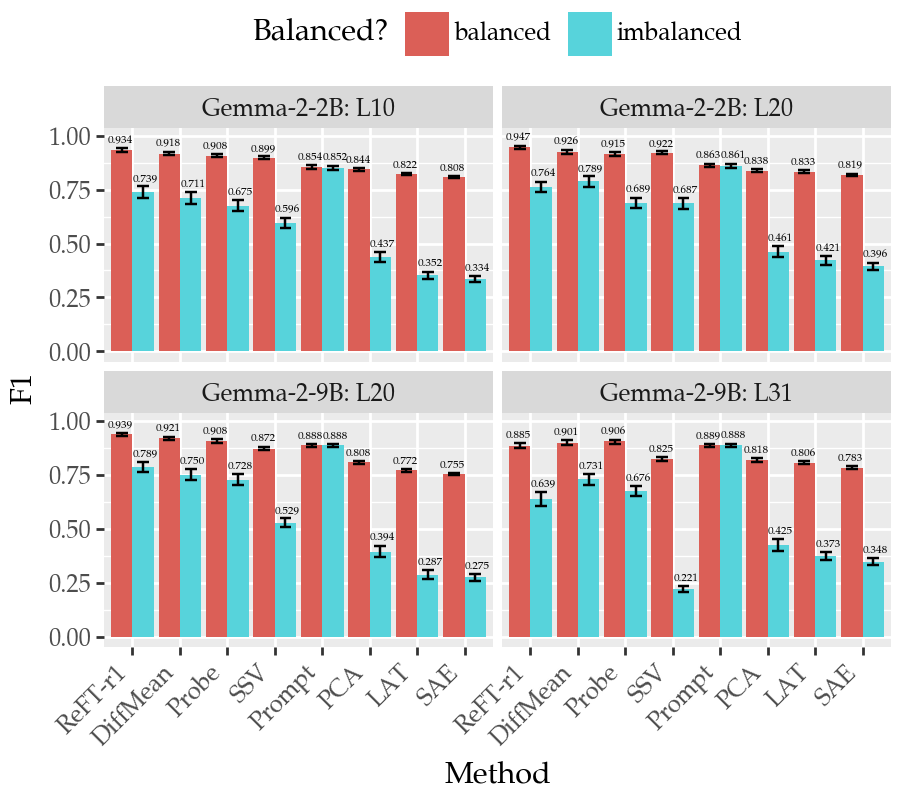

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.5 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_balance.pdf


In [19]:
plot = (
    ggplot(balance_df2, aes(x="Method", y="F1", fill="Balanced?"))
    + facet_wrap("model + ': ' + layer")
    + geom_bar(stat="identity", position=position_dodge(width=0.9))
    + geom_errorbar(aes(ymax="upper_ci", ymin="lower_ci"), position=position_dodge(width=0.9))
    + geom_text(balance_df2[balance_df2["Balanced?"] == "balanced"], aes(label="mean_formatted", y="upper_ci"), nudge_x=-0.25, nudge_y=0.035, size=4)
    + geom_text(balance_df2[balance_df2["Balanced?"] == "imbalanced"], aes(label="mean_formatted", y="upper_ci"), nudge_x=0.27, nudge_y=0.035, size=4)
    + theme(axis_text_x=element_text(hjust=1), legend_position="top", figure_size=(4.5, 4))
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_balance.pdf", width=4.5, height=4)